In [39]:
!pip install -U pip setuptools wheel
!pip install -U spacy

In [40]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 7.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [41]:
import pandas as pd
import os
import re
import numpy as np
import pysrt
import spacy
import en_core_web_sm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pickle
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gleb_tsyrulev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
def fetch_subs(path):
    data = {}
    films = os.listdir(path=path)
    for i in range(len(films)):
        subs = pysrt.open(path + films[i], encoding='iso-8859-1')
        subs_text = []
        for sub in subs:
            subs_text.append(sub.text_without_tags.split('\n'))
        data[films[i]] = subs_text
    data = pd.DataFrame({'Movie': films, 'Subtitles': data.values()})
    return data


df1 = fetch_subs('./data/')

df1

,Movie,Subtitles
0,Dredd(2012).srt,"[[America is an irradiated wasteIand.], [Withi..."
1,Despicable_Me(2010).srt,"[[Excuse me, sir,, is there a commode?], [Just..."
2,The_secret_life_of_Walter_Mitty(2013).srt,"[[Huh?], [Hi! Todd Mahar,, eHarmony.], [How ca..."
3,Shrek(2001).srt,"[[anoXmous, https://thepiratebay.se/user/Zen_B..."
4,Deadpool(2016).srt,"[[WordsKill, Edited by ahmedhamdy90 / subscene..."
...,...,...
110,Matilda(1996).srt,"[[(MUSIC)], [ NARRATOR: Everyone is born,], [b..."
111,Her(2013).srt,"[[Advertise your product or brand here, contac..."
112,The_Fundamentals_of_Caring(2016).srt,"[[Caregiving is not just, about feeding and cl..."
113,The_Intern(2015).srt,"[[Freud said, ""love and work., Work and love.]..."


In [43]:
df1['Movie'] = [i[:-4] for i in df1['Movie']]

In [44]:
df1.loc[1,'Subtitles']

[['Excuse me, sir,', 'is there a commode?'],
 ['Justin!'],
 ['Quick, honey, take my picture.', 'I got the pyramid in my hand.'],
 ['Justin, you get back here', 'right now!'],
 ['No, stop!'],
 ['- No, no! Stop him!', "- Go back! Don't climb!"],
 ['Wait, wait.'],
 ['Hold on. Easy, little boy.'],
 ['Okay, stop, child!', 'Stop right there. No!'],
 ['No, no, no! There he goes.'],
 ['Justin!'],
 ["I've got him! I've got him!"],
 ['Outrage in Egypt tonight', 'as it was discovered'],
 ['that the Great Pyramid of Giza', 'had been stolen'],
 ['and replaced', 'by a giant inflatable replica.'],
 ['There is panic throughout the globe', 'as countries and citizens'],
 ['try to protect', 'their beloved landmarks.'],
 ['Law enforcement', 'still has no leads,'],
 ['leaving everyone to wonder,', "which of the world's villains"],
 ['is responsible', 'for this heinous crime?'],
 ['And where will he strike next?'],
 ["I'm having a bad, bad day"],
 ["It's about time", 'that I get my way'],
 ['Steamrolling wh

In [45]:
df2 = pd.read_excel('./movies_labels.xlsx')
df = df2.merge(df1, on ='Movie')
df = df.drop(['id'], axis=1)
df.sample(5)

,Movie,Level,Subtitles
105,Venom(2018),B2,"[[Life, Foundation Control, this is LF1.], [Th..."
11,Beauty_and_the_beast(2017),B2,"[[Once upon a time,, in the hidden heart of Fr..."
59,Milada(2017),B1,"[[Subtitles by explosiveskull], [Thank you.], ..."
81,The_Legend_of_Tarzan(2016),C1,"[[Monsieur Rom...], [Opar.], [(INHALES DEEPLY)..."
88,The_graduate(1967),"B1, B2","[[Ladies and gentlemen, we are about, to begin..."


In [46]:
print(df['Level'].unique())

df['Level']= df['Level'].replace('A2/A2+','A2')
df['Level']= df['Level'].replace('A2/A2+, B1','B1')
df['Level']= df['Level'].replace('B1, B2','B2')

print(df['Level'].unique())

['B1' 'B2' 'A2/A2+' 'C1' 'B1, B2' 'A2/A2+, B1']
['B1' 'B2' 'A2' 'C1']


In [31]:
# importing os module 
import os
  
# Get the path of current working directory
path = r'./English_scores/Subtitles_all/'
  
# Get the list of all files and directories
# in current working directory
dir_list = os.listdir(path)
  
  
print("Files and directories in '", path, "' :") 
# print the list
print(dir_list)

Files and directories in ' ./English_scores/Subtitles_all/ ' :
['.DS_Store', 'B2', 'A2', 'C1', 'B1']


In [71]:
df_list = []
counter = 0
for item in dir_list:
    if '.' in item:
        pass
    else:
        df_list.append(fetch_subs(path+item+'/'))
        df_list[counter]['Level'] = item
        display(df_list[counter].head(1))
        counter += 1
        

df_extra = pd.concat(df_list,axis=0,ignore_index=True)
df_extra['Movie'] = [i[:-4] for i in df_extra['Movie']]

display(df_extra.sample(10))

,Movie,Subtitles,Level
0,"Crown, The S01E01 - Wolferton Splash.en.srt","[[In seeking his British, nationalization, His...",B2


,Movie,Subtitles,Level
0,The Walking Dead-S01E03-Tell It To The Frogs.E...,"[[( thunder rumbling )], [Merle:, That's right...",A2


,Movie,Subtitles,Level
0,Suits S04E11 EngSub.srt,[],C1


,Movie,Subtitles,Level
0,Seven.Worlds.One.Planet.S01E06.2160p.BluRay.Re...,"[[One continent on our planet changes], [more ...",B1


,Movie,Subtitles,Level
56,Suits.S01E11.1080p.BluRay.AAC5.1.x265-DTG.02.EN,"[[Are you watching me?], [Do I look dashing?],...",B2
108,The Walking Dead-S01E05-Wildfire.English,"[[- ( walkie-talkie squawks ), - Rick: Morgan,...",A2
60,Suits.S01E01.1080p.BluRay.AAC5.1.x265-DTG.02.EN,"[[Gerald Tate's here. He wants to know, what's...",B2
61,z srt23 uk-bun Gullivers.Travels.1939.720p.Blu...,"[[23.976 English], [Gulliver's Travels (1939)]...",B2
126,Suits S04E07 EngSub,[],C1
11,"Crown, The S01E05 - Smoke and Mirrors.en","[[Yes.], [Ah, there you are. Come in.], [I'm p...",B2
15,Collateral.Beauty.2016.720p.BRRip.x264.AAC-ETRG,"[[Common errors, OCR and, capitalization issue...",B2
121,Suits S04E02 EngSub,[],C1
151,Men.In.Black.1997.720p.Bluray.x264-SEPTiC,"[[Goddamn bugs.], [Oh, shit!], [Oh, crap.], [W...",B1
23,Suits.Episode 16- 25th Hour,"[[ - Previously, on ""Suits""...], [- Has ruined...",B2


In [73]:
data = pd.concat([df,df_extra],axis=0,ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Movie      273 non-null    object
 1   Level      273 non-null    object
 2   Subtitles  273 non-null    object
dtypes: object(3)
memory usage: 6.5+ KB


In [98]:
X,y = data['Subtitles'], data['Level']

In [99]:
nlp = spacy.load("en_core_web_sm")

In [100]:
def preprocess(text):
    # удаление символов
    document = re.sub(r'\W', ' ', str(text))
    # удаление одиноко стоящих слов
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # приведение к нижнему регистру 
    document = document.lower()
    # токенизация
    #document = nltk.word_tokenize(document,language = "english")
    # лемматизация
    spacy_results = nlp(document)
    document = ' '.join([token.lemma_ for token in spacy_results])
    return document

In [101]:
X = X.apply(preprocess)

In [102]:
print(X[1:10])

1        hey ll be right with you        so   camer...
2        resync   xenzai nef      retail       shou...
3           sync and correct by mrcjnthn          g...
4        oh come from land     from faraway place  ...
5        captioning make possible by     mgm home e...
6         indistinct conversation         all laugh...
7        this be tale aboutan unprejudiced heart   ...
8        october be inventory time        so right ...
9        download from     yts mx       official yi...
Name: Subtitles, dtype: object


In [103]:
vectorizer = CountVectorizer(max_features=4000, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(X).toarray()

In [104]:
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

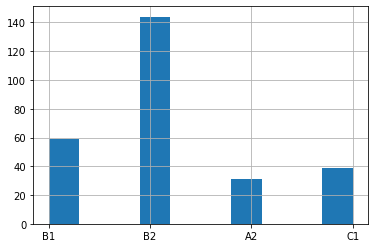

In [105]:
y.hist();

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 23)

In [107]:
print(f"""
      total:\t {X.shape}
      train:\t {X_train.shape}
      test:\t {X_test.shape}
      """)


      total:	 (273, 4000)
      train:	 (191, 4000)
      test:	 (82, 4000)
      


In [108]:
train_pool = Pool(X_train, 
                  y_train)

test_pool = Pool(X_test, y_test) 

model = CatBoostClassifier(verbose=False)
#train the model
model.fit(train_pool) 

In [109]:
predict_train = model.predict(X_train)
print(accuracy_score(y_train, predict_train))

1.0


In [110]:
preds = model.predict(test_pool)
accuracy_score(preds, y_test)

0.6951219512195121

In [111]:
y.value_counts()

B2    144
B1     59
C1     39
A2     31
Name: Level, dtype: int64

In [124]:
# import ClassificationExperiment and init the class
from pycaret.classification import *

In [128]:
s = setup(X, target = y, session_id = 23, fold=3)

,Description,Value
0,Session id,23
1,Target,Level
2,Target type,Multiclass
3,Target mapping,"A2: 0, B1: 1, B2: 2, C1: 3"
4,Original data shape,"(273, 4001)"
5,Transformed data shape,"(273, 4001)"
6,Transformed train set shape,"(191, 4001)"
7,Transformed test set shape,"(82, 4001)"
8,Numeric features,4000
9,Preprocess,True


In [129]:
# compare baseline models
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.7072,0.0000,0.7072,0.7783,0.6784,0.5098,0.5453,0.3800
nb,Naive Bayes,0.6808,0.7155,0.6808,0.6840,0.6423,0.4577,0.4785,0.1600
ridge,Ridge Classifier,0.6442,0.0000,0.6442,0.6360,0.5862,0.3734,0.4101,0.1200
catboost,CatBoost Classifier,0.6389,0.8441,0.6389,0.6633,0.5839,0.3359,0.3909,48.3033
lr,Logistic Regression,0.6285,0.8393,0.6285,0.6851,0.5427,0.2745,0.3851,0.7767
et,Extra Trees Classifier,0.6284,0.8607,0.6284,0.7050,0.5613,0.2979,0.3769,0.2033
rf,Random Forest Classifier,0.6234,0.8399,0.6234,0.6421,0.5466,0.2763,0.3563,0.2267
lightgbm,Light Gradient Boosting Machine,0.6179,0.8362,0.6179,0.6271,0.5932,0.3389,0.3550,0.3500
gbc,Gradient Boosting Classifier,0.6128,0.8231,0.6128,0.6041,0.5829,0.3286,0.3460,2.3867
lda,Linear Discriminant Analysis,0.6073,0.8225,0.6073,0.5859,0.5780,0.3275,0.3396,0.1833


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

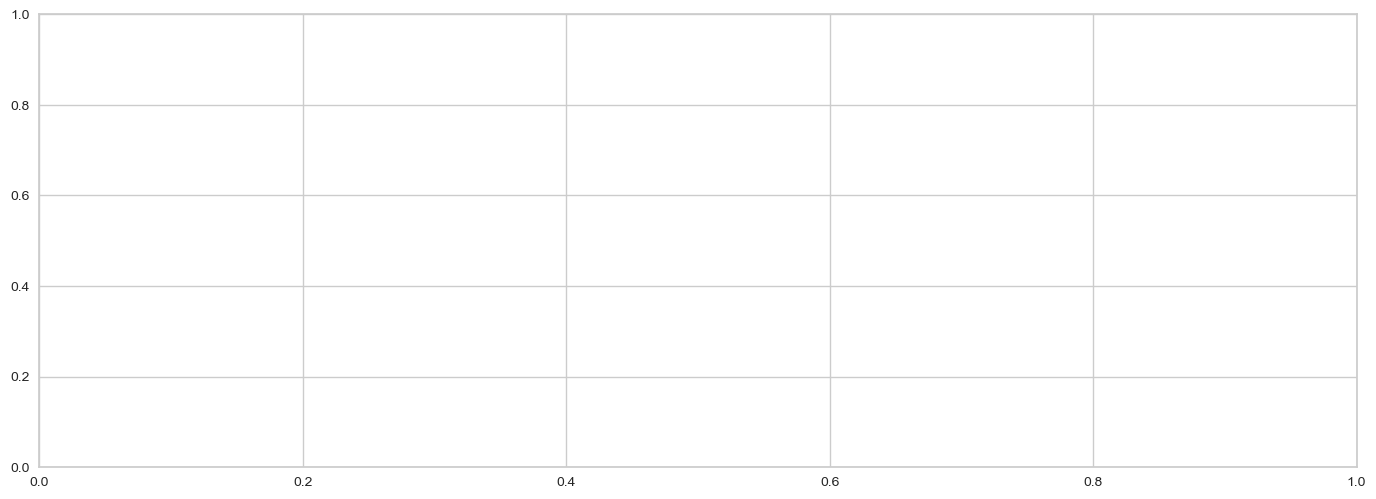

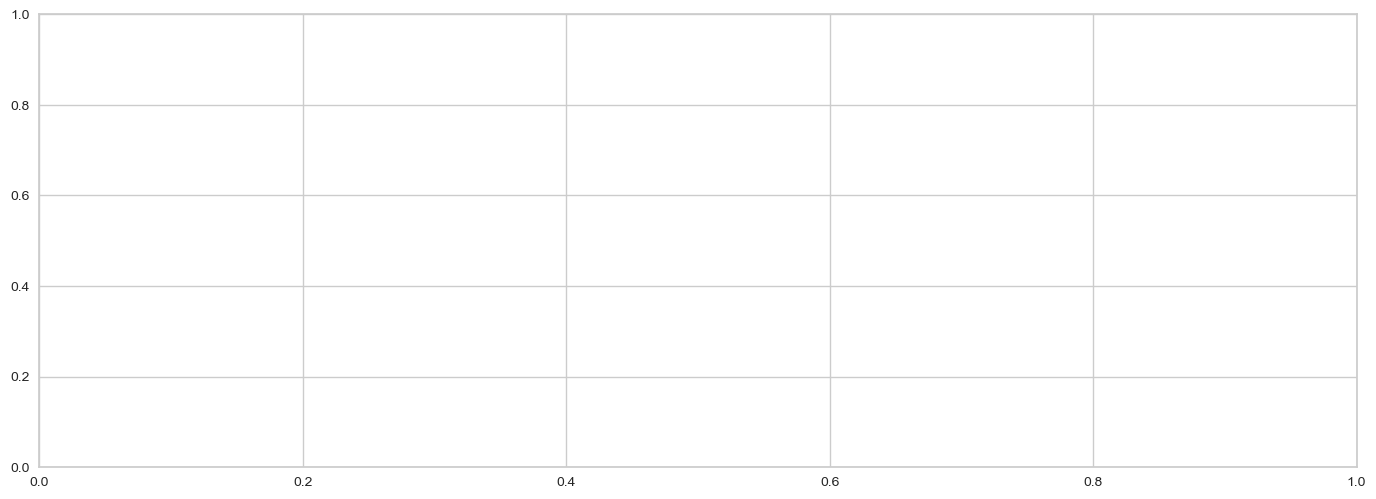

In [143]:
evaluate_model(best)

In [147]:
save_model(best, model_name = 'language_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/var/folders/rt/h59slvxd0c54py8vndb3fm8h0000gn/T/joblib),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['feature_1', 'feature_2',
                                              'feature_3', 'feature_4',
                                              'feature_5', 'feature_6',
                                              'feature_7', '...
                 ('trained_model',
                  SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                                early_stopping=False, epsilon=0.1, eta0=0.001,
                                fit_intercept=True, l1_ratio=0.15,
                                learning_rate='optimal', loss='hinge',
             

In [171]:
model = load_model('language_model')

Transformation Pipeline and Model Successfully Loaded


In [265]:
subs = pysrt.open('./data/Aladdin(1992).srt', encoding='iso-8859-1')
    
text = re.sub('<i>|</i>', '', subs.text)
text = re.sub('\<.*?\>', '', text)      
text = re.sub('\n', ' ', text)               
text = re.sub('\(.*?\)', '', text)           
text = re.sub('\[.*?\]', '', text)           
text = re.sub('[A-Z]+?:', '', text)          
text = re.sub('\.+?:', '\.', text)           
text = text.lower()
text = re.sub('[^a-z\.\!\?]', ' ', text)     
text = re.sub(' +', ' ', text)               
spacy_results = nlp(text)
text = ' '.join([token.lemma_ for token in spacy_results])
text = [text]
text = vectorizer.fit_transform(text).toarray()
text = tfidfconverter.fit_transform(text).toarray()
# text = pd.DataFrame(text)
print(text)



[[0.0122338  0.03670139 0.00815586 ... 0.00407793 0.00815586 0.00407793]]


In [266]:
temp = text.copy()
print(temp.shape)
N = 0
if temp.shape[1] < 4000:
    N = 4000 - temp.shape[1]
    text = np.pad(text, ((0, 0), (0, N)), 'constant')
print(text.shape)

(1, 1199)
(1, 4000)


In [267]:
col = []
for i in range(1,4001):
    col.append('feature_'+str(i))
col[-5:]
df = pd.DataFrame(text, columns=col)
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_3991,feature_3992,feature_3993,feature_3994,feature_3995,feature_3996,feature_3997,feature_3998,feature_3999,feature_4000
0,0.012234,0.036701,0.008156,0.004078,0.004078,0.004078,0.004078,0.004078,0.142728,0.016312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [269]:
predict_model(model, df)['prediction_label']

0    A2
Name: prediction_label, dtype: object

In [270]:
def predict_level(model, df):
    
    predictions = predict_model(model, data = df)['prediction_label']
    return predictions

print(f'This film is labeled **:[{predict_level(model, df)[0]}]** on CEFR classification')

This film is labeled **:[A2]** on CEFR classification
